# **KMRL Passenger Trend Prediction using Facebook's Prophet**
![](https://miro.medium.com/max/964/0*tVCene42rgUTNv9Q.png)

# **Install and Import Necessary Modules**

In [1]:
# Install the Facebook Prophet module
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 765.8 kB/s eta 0:00:000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 2.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 459.2 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.9/499.9 kB 1.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 591.0 kB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 2.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml

In [6]:
# Import the necessary modules

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# **Data**
Original passenger data from Kochi Metro has not yet been made available and hence the data we will be using is hourly power consumption data from PJM (Electricity supplier in the Unites States). This data is analogous to hourly passenger category count data and will suffice for demonstrating our predicition process. 

**The passenger categories are as follows:**


*   Male 0-16 years (denoted as **M0_16**)
*   Male 17-30 years (denoted as **M17_30**)
*   Male 31-45 years (denoted as **M31_45**)
*   Male >45 years (denoted as **M45_**)
*   Female 0-16 years (denoted as **F0_16**)
*   Female 17-30 years (denoted as **F17_30**)
*   Female 31-45 years (denoted as **F31_45**)
*   Female >45 years (denoted as **F45_**)
 
For this Notebook we will be using the data from the year 2004 upto 2018.
 

In [7]:
# Install mega.py module required to download the input CSV file from the Mega Cloud Storage
!pip install mega.py

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 444.2 kB/s eta 0:00:000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.9/195.9 kB 1.1 MB/s eta 0:00:0000:0100:01
  Using cached idna-3.4-py3-none-any.whl (61 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.2/123.2 kB 896.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.0/157.0 kB 1.0 MB/s eta 0:00:0000:0100:01


In [8]:
# Download the input CSV file from the Mega Cloud Storage
from mega import Mega
mega = Mega()
m = mega.login()
m.download_url('https://mega.nz/file/Z04mwYRZ#tpFM4_Tsq3i3eTe2y1CkQG2eoE3rqqCrh_EsH2bfezM')

PosixPath('KMRLInput.csv')

In [9]:
# Specify the passenger category you want to make predictions on
category="M17_30"

In [10]:
# Read the input CSV file and convert it into a DataFrame
data = pd.read_csv('KMRLInput.csv',
                   index_col=[0],
                  parse_dates=[0])
data=data[[category]]
data.head()

,M17_30
Datetime,
2004-12-31 01:00:00,12
2004-12-31 02:00:00,10
2004-12-31 03:00:00,9
2004-12-31 04:00:00,9
2004-12-31 05:00:00,9


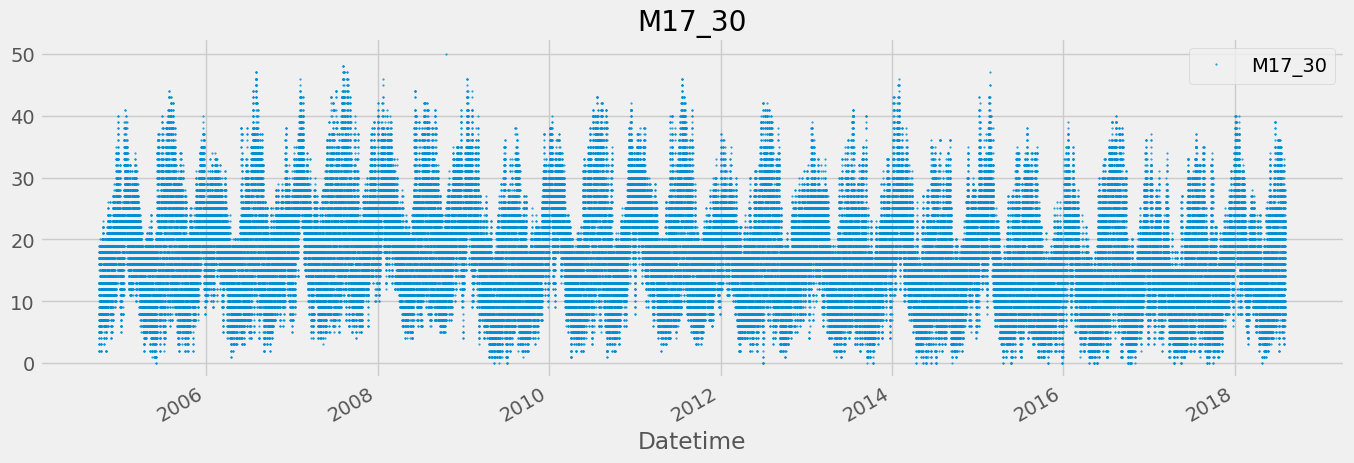

In [11]:
# Dataset Plot
color_pal = sns.color_palette()
data.plot(style='.',
          figsize=(15, 5),
          ms=1,
          color=color_pal[0],
          title=category)
plt.show()

# **Train / Test Split**

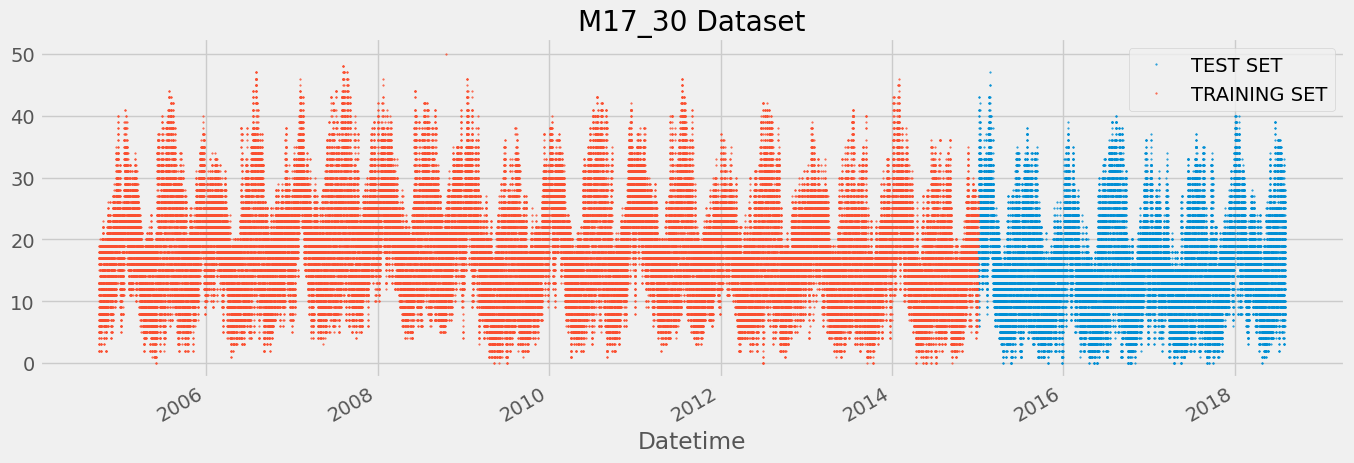

In [16]:
# Split the input Dataframe into Train and Test Dataframes
split_date = '1-Jan-2015'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

# Plot the Train and Test data so we can see where we have split
data_test \
    .rename(columns={category: 'TEST SET'}) \
    .join(data_train.rename(columns={category: 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15, 5), title=category+' Dataset', style='.', ms=1)
plt.show()

# **Train Prophet Model**
- Prophet model expects the dataset to be named a specific way. We will rename our dataframe columns before feeding it into the model.
    - Datetime column named: `ds`
    - target : `y`

In [18]:
# Format data for prophet model using ds and y
data_train_prophet = data_train.reset_index() \
    .rename(columns={'Datetime':'ds',
                     category:'y'})

In [20]:
# Train the model
# %%time
model = Prophet()
# We can make the model consider Indian Public Holidays while making the predicitons with the built-in add_country_holidays() method 
Prophet.add_country_holidays(model, country_name = 'IN')
model.fit(data_train_prophet)

10:27:35 - cmdstanpy - INFO - Chain [1] start processing
10:30:27 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
# List out all the holidays considered while making predicitions
model.train_holiday_names

0                        Republic Day
1                    Independence Day
2                      Gandhi Jayanti
3                       Day of Ashura
4                              Mawlid
5                         Eid al-Fitr
6              Feast of the Sacrifice
7                      New Year's Day
8                         Palm Sunday
9                     Maundy Thursday
10                        Good Friday
11                      Easter Sunday
12                 Feast of Pentecost
13    Fest of St. Theresa of Calcutta
14        Feast of the Blessed Virgin
15                     All Saints Day
16                      All Souls Day
17                      Christmas Day
18                         Boxing Day
19               Feast of Holy Family
20                             Diwali
21                               Holi
dtype: object

# **Make Predictions**

In [22]:
# Forecast for a particular DateTime
test_datetime='2015-01-02 8:00:00'
test_case_data = {'ds': [pd.to_datetime(test_datetime)],'y': [0]}
df = pd.DataFrame(test_case_data,index=[0])
test_case_fcst=model.predict(df)
# yhat gives the prediction value
display(test_case_fcst)
# print(test_case_fcst.yhat)
# actual value
display(data[data.index==test_datetime])

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints Day,All Saints Day_lower,All Saints Day_upper,All Souls Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02 08:00:00,16.358034,13.970795,26.322346,16.358034,16.358034,0.0,0.0,0.0,0.0,...,1.186994,1.186994,1.186994,2.636078,2.636078,2.636078,0.0,0.0,0.0,20.26475


,M17_30
Datetime,
2015-01-02 08:00:00,21


In [23]:
# Predict on test set with model
data_test_prophet = data_test.reset_index() \
    .rename(columns={'Datetime':'ds',
                     category:'y'})

data_test_fcst = model.predict(data_test_prophet)

In [24]:
# An example of the predicition output
data_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints Day,All Saints Day_lower,All Saints Day_upper,All Souls Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,16.359855,5.276518,16.954189,16.359855,16.359855,0.0,0.0,0.0,0.0,...,1.840222,1.840222,1.840222,2.544394,2.544394,2.544394,0.0,0.0,0.0,10.981346
1,2015-01-01 02:00:00,16.359797,3.229772,15.409120,16.359797,16.359797,0.0,0.0,0.0,0.0,...,1.843696,1.843696,1.843696,2.546273,2.546273,2.546273,0.0,0.0,0.0,9.355178
2,2015-01-01 03:00:00,16.359738,2.527577,14.441748,16.359738,16.359738,0.0,0.0,0.0,0.0,...,1.845207,1.845207,1.845207,2.548224,2.548224,2.548224,0.0,0.0,0.0,8.561276
3,2015-01-01 04:00:00,16.359679,3.268067,14.815236,16.359679,16.359679,0.0,0.0,0.0,0.0,...,1.844782,1.844782,1.844782,2.550247,2.550247,2.550247,0.0,0.0,0.0,8.735377
4,2015-01-01 05:00:00,16.359620,3.589853,15.889353,16.359620,16.359620,0.0,0.0,0.0,0.0,...,1.842469,1.842469,1.842469,2.552342,2.552342,2.552342,0.0,0.0,0.0,9.911731


In [25]:
# Filter the forecast result for a particular DateTime
filter_datetime='2015-01-02 8:00:00'
display(data_test_fcst[data_test_fcst.ds==filter_datetime])
# actual value
display(data[data.index==filter_datetime])

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,All Saints Day,All Saints Day_lower,All Saints Day_upper,All Souls Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
31,2015-01-02 08:00:00,16.358034,14.492693,26.341326,16.358034,16.358034,0.0,0.0,0.0,0.0,...,1.186994,1.186994,1.186994,2.636078,2.636078,2.636078,0.0,0.0,0.0,20.26475


,M17_30
Datetime,
2015-01-02 08:00:00,21


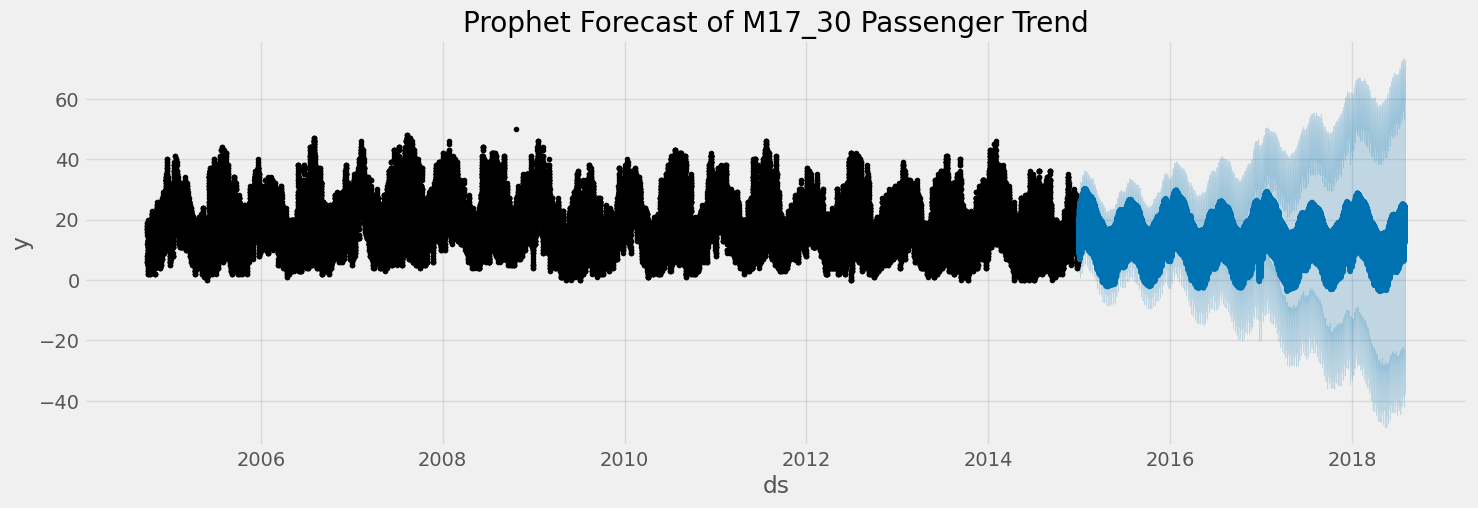

In [26]:
# Plot of forecast
fig, ax = plt.subplots(figsize=(15, 5))
fig = model.plot(data_test_fcst, ax=ax)
ax.set_title('Prophet Forecast of '+category+' Passenger Trend')
plt.show()

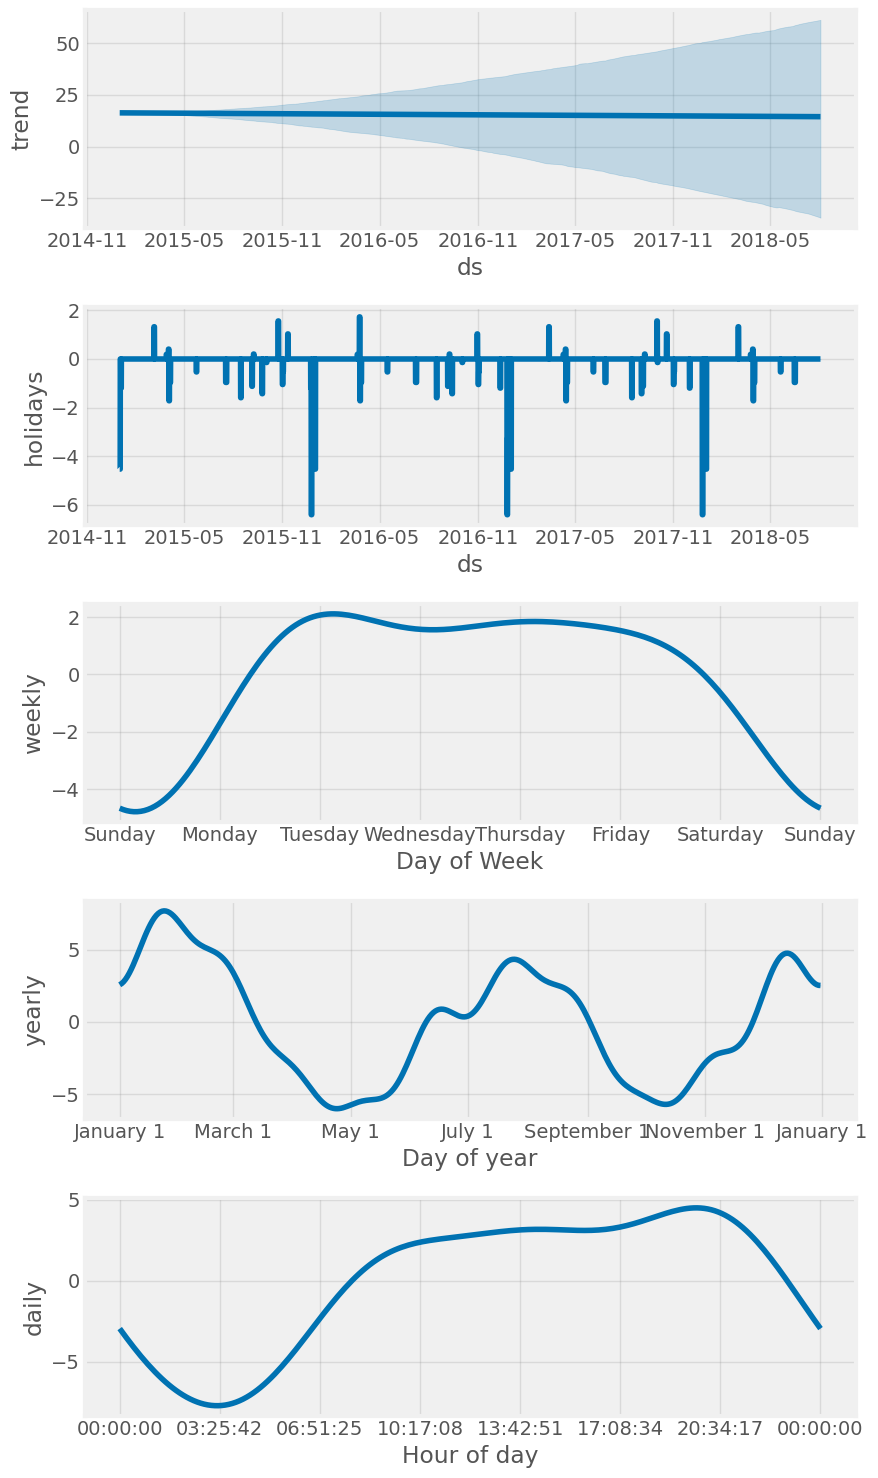

In [27]:
# Plot of components of forecast
fig = model.plot_components(data_test_fcst)
plt.show()

# **Compare Forecast to Actuals**

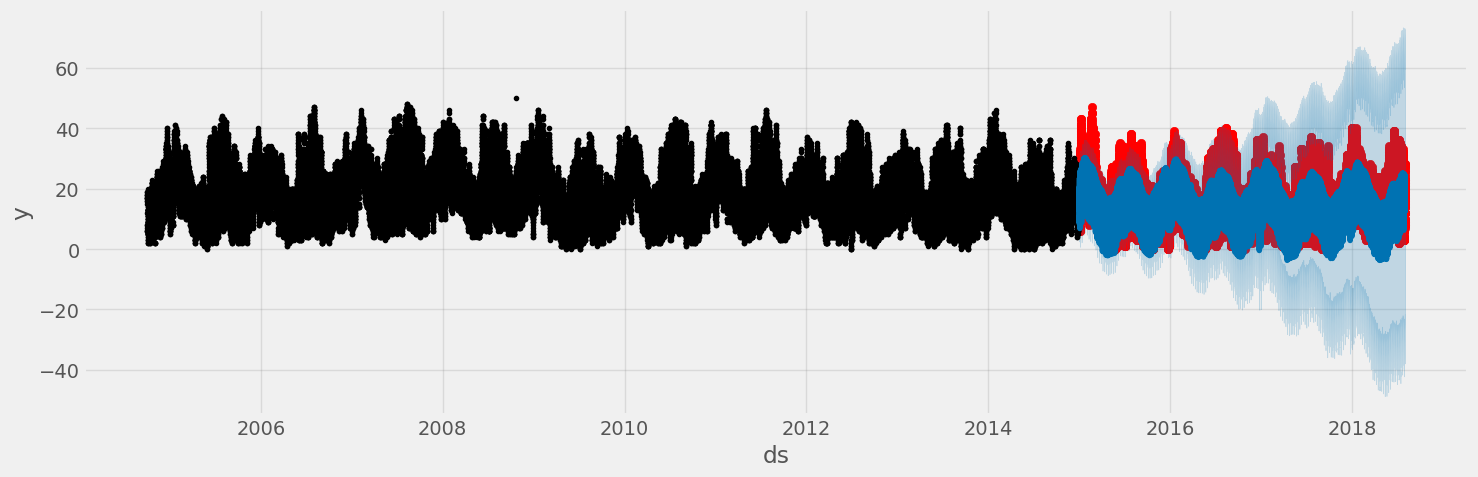

In [28]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test[category], color='r')
fig = model.plot(data_test_fcst, ax=ax)

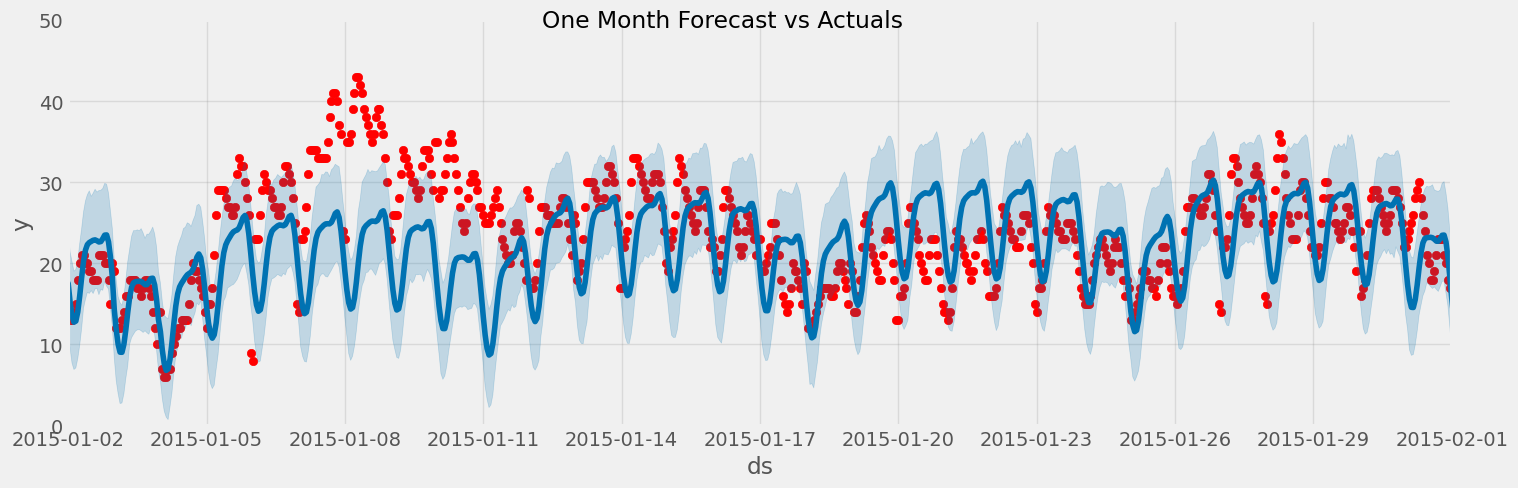

In [29]:
# One Month Forecast vs Actuals Comparision Plot
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test[category], color='r')
fig = model.plot(data_test_fcst, ax=ax)
# ax.set_xbound(lower='01-01-2015',
#               upper='02-01-2015')
ax.set_xlim([pd.to_datetime('02-01-2015', format = '%d-%m-%Y'),
             pd.to_datetime('01-02-2015', format = '%d-%m-%Y')])
ax.set_ylim(0, 50)
plot = plt.suptitle('One Month Forecast vs Actuals')

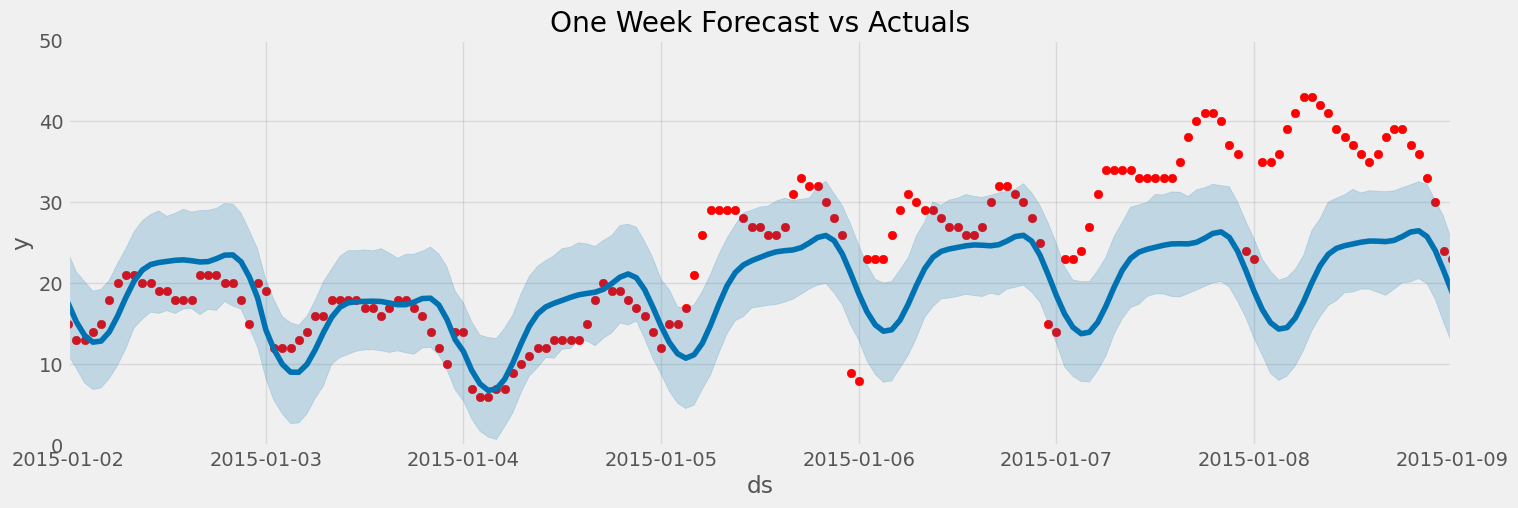

In [30]:
# One Week Forecast vs Actuals Comparision Plot
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test[category], color='r')
fig = model.plot(data_test_fcst, ax=ax)
# ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_xlim([pd.to_datetime('02-01-2015', format = '%d-%m-%Y'),
             pd.to_datetime('09-01-2015', format = '%d-%m-%Y')])
ax.set_ylim(0, 50)
ax.set_title('One Week Forecast vs Actuals')
plt.show()

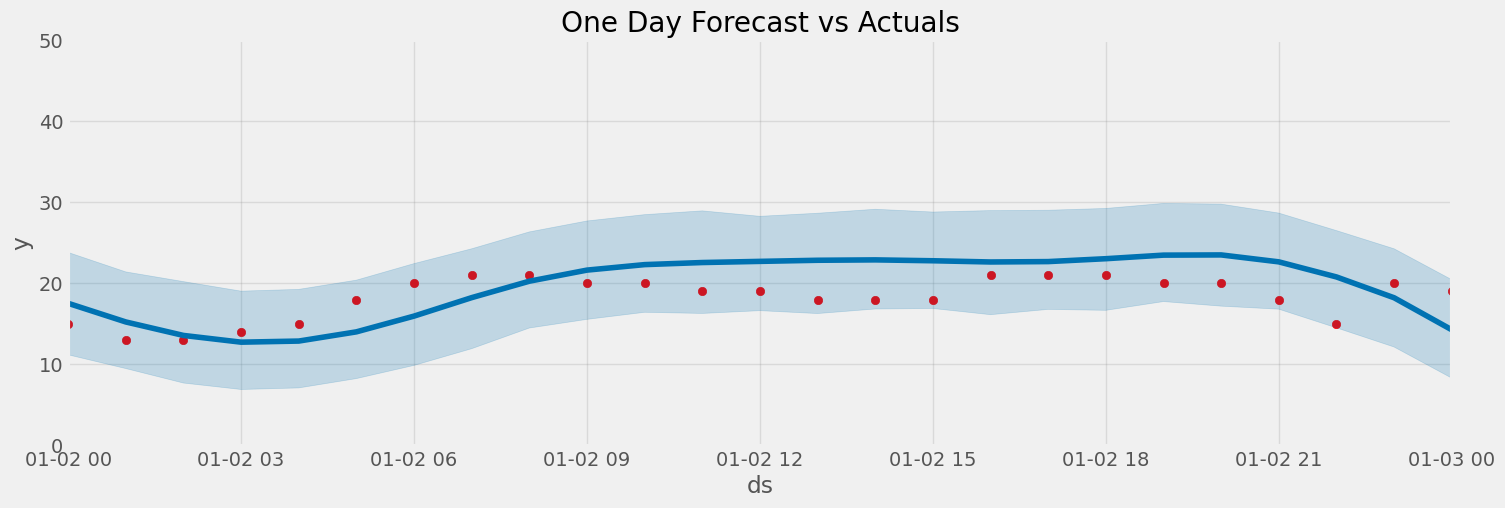

In [31]:
# One Day Forecast vs Actuals Comparision Plot
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data_test.index, data_test[category], color='r')
fig = model.plot(data_test_fcst, ax=ax)
# ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_xlim([pd.to_datetime('02-01-2015', format = '%d-%m-%Y'),
             pd.to_datetime('03-01-2015', format = '%d-%m-%Y')])
ax.set_ylim(0, 50)
ax.set_title('One Day Forecast vs Actuals')
plt.show()

# **Evaluate the model with Error Metrics**

In [32]:
# RMSE (Root Mean Sqaure Error)
np.sqrt(mean_squared_error(y_true=data_test[category],
                   y_pred=data_test_fcst['yhat']))

8.016256419643275

In [33]:
# MAE (Mean Absolute Error)
mean_absolute_error(y_true=data_test[category],
                   y_pred=data_test_fcst['yhat'])

6.314461627599209

In [34]:
# MAPE (Mean Absolute Percentage Error)
mean_absolute_percentage_error(y_true=data_test[category],
                   y_pred=data_test_fcst['yhat'])

inf